In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

# Conditional Entropy: Can Information Theory Beat the L-S Periodogram?

**Version 0.2**

***
By AA Miller  
23 Sep 2021

[Lecture IV](https://github.com/LSSTC-DSFP/LSSTC-DSFP-Sessions/blob/main/Session13/Day4/NonparametricMeasuresOfPeriodicity.ipynb) focused on alternative methods to Lomb-Scargle when searching for periodic signals in astronomical time series. In this notebook you will develop the software necessary to search for periodicity via Conditional Entropy (my personal favorite method). 

#### Conditional Entropy

Conditional Entropy (CE; [Graham et al. 2013](http://adsabs.harvard.edu/abs/2013MNRAS.434.2629G)), and other entropy based methods, aim to minimize the entropy in binned (normalized magnitude, phase) space. CE, in particular, is good at supressing signal due to the window function.

When tested on real observations, CE outperforms most of the alternatives (e.g., LS, PDM, etc).

<img style="display: block; margin-left: auto; margin-right: auto" src="./images/CE.png" align="middle">

<div align="right"> <font size="-3">(credit: Graham et al. 2013) </font></div>

## Conditional Entropy

The focus of today's exercise is conditional entropy (CE), which uses information theory and thus, in principle, works better in the presence of noise and outliers. Furthermore, CE does not make any assumptions about the underlying shape of the signal, which is useful when looking for non-sinusoidal patterns (such as transiting planets or eclipsing binaries).

For full details on the CE algorithm, see [Graham et al. (2013)](http://adsabs.harvard.edu/abs/2013MNRAS.434.2629G).

Briefly, CE is based on the using the Shannon entropy ([Cincotta et al. 1995](https://ui.adsabs.harvard.edu/abs/1995ApJ...449..231C/abstract)), which is determined as follows:

  - Normalize the time series data $m(t_i)$ to occupy a uniform square over phase, $\phi$, and magnitude, $m$, at a given trial period, $p$. 

  - Calculate the Shannon entropy, $H_0$, over the $k$ partitions in $(\phi, m)$:

 $$H_0 = - \sum_{i=1}^{k} \mu_i \ln{(\mu_i)}\;\; \forall \mu_i \ne 0,$$
 where $\mu_i$ is the occupation probability for the $i^{th}$ partition, which is just the number of data points in that partition divided by the total number of points in the data set.


  - Iterate over multiple periods, and identify the period that minimizes the entropy (recall that entropy measures a lack of information)

As discussed in [Graham et al. (2013)](http://adsabs.harvard.edu/abs/2013MNRAS.434.2629G), minimizing the Shannon entropy can be influenced by the window function, so they introduce the conditional entropy, $H_c(m|\phi)$, to help mitigate these effects. The CE can be calculated as:

$$H_c =  \sum_{i,j} p(m_i, \phi_j) \ln \left( \frac{p(\phi_j)}{p(m_i, \phi_j)} \right), $$
where $p(m_i, \phi_j)$ is the occupation probability for the $i^{th}$ partition in normalized magnitude and the $j^{th}$
partition in phase and $p(\phi_j)$ is the occupation probability of the $j^{th}$ phase partition

In this problem we will first calculate the Shannon entropy, then the CE to find the best-fit period of the eclipsing binary from the LS lecture.

## Problem 1) Helper Functions

**Problem 1a**

Create a function, `gen_periodic_data`, that creates simulated data (including noise) over a grid of user supplied positions:

$$ y = A\,cos\left(\frac{2{\pi}x}{P} - \phi\right) + \sigma_y$$

where $A, P, \phi$ are inputs to the function. `gen_periodic_data` should include Gaussian noise, $\sigma_y$, for each output $y_i$.

In [3]:
def gen_periodic_data(x, period=1, amplitude=1, phase=0, noise=0):
    '''Generate periodic data given the function inputs
    
    y = A*cos(x/p - phase) + noise
    
    Parameters
    ----------
    x : array-like
        input values to evaluate the array
    
    period : float (default=1)
        period of the periodic signal
    
    amplitude : float (default=1)
        amplitude of the periodic signal
    
    phase : float (default=0)
        phase offset of the periodic signal
    
    noise : float (default=0)
        variance of the noise term added to the periodic signal
    
    Returns
    -------
    y : array-like
        Periodic signal evaluated at all points x
    '''
    
    y = amplitude*np.sin(2*np.pi*x/(period) - phase) + np.random.normal(0, np.sqrt(noise), size=len(x))
    return y

**Problem 1b**

Create a function, `phase_plot`, that takes x, y, and $P$ as inputs to create a phase-folded light curve (i.e., plot the data at their respective phase values given the period $P$).

Include an optional argument, `y_unc`, to include uncertainties on the `y` values, when available.

In [4]:
def phase_plot(x, y, period, y_unc = 0.0):
    '''Create phase-folded plot of input data x, y
    
    Parameters
    ----------
    x : array-like
        data values along abscissa

    y : array-like
        data values along ordinate

    period : float
        period to fold the data
        
    y_unc : array-like
        uncertainty of the 
    '''    
    phases = (x/period) % 1
    if type(y_unc) == float:
        y_unc = np.zeros_like(x)
        
    plot_order = np.argsort(phases)
    norm_y = (y - np.min(y))/(np.max(y) - np.min(y))
    norm_y_unc = (y_unc)/(np.max(y) - np.min(y))
    
    plt.rc('grid', linestyle=":", color='0.8')
    fig, ax = plt.subplots()
    ax.errorbar(phases[plot_order], norm_y[plot_order], norm_y_unc[plot_order],
                 fmt='o', mec="0.2", mew=0.1)
    ax.set_xlabel("phase")
    ax.set_ylabel("signal")
    ax.set_yticks(np.linspace(0,1,11))
    ax.set_xticks(np.linspace(0,1,11))
    ax.grid()
    fig.tight_layout()

**Problem 1c**

Generate a signal with $A = 2$, $p = \pi$, and Gaussian noise with variance = 0.01 over a regular grid between 0 and 10. Plot the phase-folded results (and make sure the results behave as you would expect).

*Hint* - your simulated signal should have at least 100 data points.

<IPython.core.display.Javascript object>


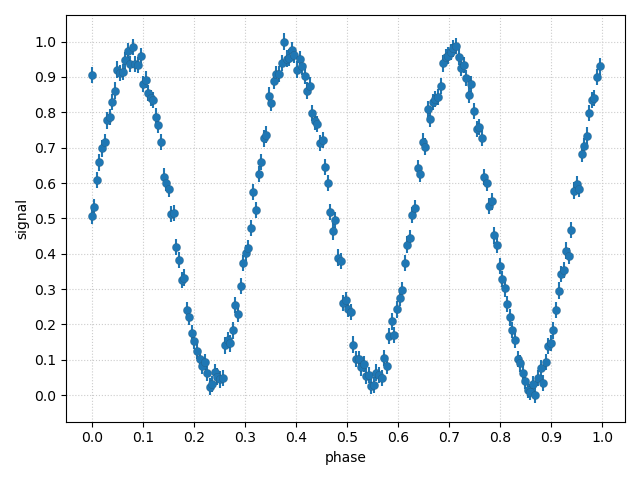

In [40]:
x = np.linspace(0,10,200)
y = gen_periodic_data(x, period=np.pi, amplitude=2, phase=0, noise=0.01)

phase_plot(x, y, np.pi, y_unc = np.full(len(x),np.sqrt(0.01)))

Note a couple changes from the previous helper function –– we have added a grid to the plot (this will be useful for visualizing the entropy), and we have also normalized the brightness measurements from 0 to 1. 

## Problem 2) The Shannon entropy

As noted above, to calculate the Shannon entropy we need to sum the data over partitions in the normalized $(\phi, m)$ plane.

This is straightforward using [`histogram2d`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram2d.html) from numpy. 

**Problem 2a** 

Write a function `shannon_entropy` to calculate the Shannon entropy, $H_0$, for a timeseries, $m(t_i)$, at a given period, `p`.

*Hint* - use `histogram2d` and a 10 x 10 grid (as plotted above). 

In [6]:
def shannon_entropy(m, t, p):
    '''Calculate the Shannon entropy
    
    Parameters
    ----------
    m : array-like
        brightness measurements of the time-series data
    
    t : array-like (default=1)
        timestamps corresponding to the brightness measurements
    
    p : float
        period of the periodic signal
        
    Returns
    -------
    H0 : float
        Shannon entropy for m(t) at period p
    '''
    
    m_norm = (m-m.min())/m.ptp()
    phases = (t/p)%1
    H, _, _ = np.histogram2d(phases,m_norm,bins=(np.linspace(0,1,11),np.linspace(0,1,11)))
    
    mu = H/H.sum()
    
    occupied = np.where(H > 0) # ?? how in particular does Adam use this
    
    H0 = -np.sum(mu[H>0]*np.log(mu[H>0]))
    
    
    return H0

**Problem 2b**

What is the Shannon entropy for the simulated signal at periods = 1, $\pi$-0.05, and $\pi$?

Do these results make sense given your understanding of the Shannon entropy?

In [7]:
print('For p = 1, \t\tH_0 = {:.5f}'.format(shannon_entropy(y,x,1)))
print('For p = pi - 0.05, \tH_0 = {:.5f}'.format(shannon_entropy(y,x,np.pi-0.05)))
print('For p = pi, \t\tH_0 = {:.5f}'.format(shannon_entropy(y,x,np.pi)))

For p = 1, 		H_0 = 4.17335
For p = pi - 0.05, 	H_0 = 3.27676
For p = pi, 		H_0 = 3.18401


We know the correct period of the simulated data is $\pi$, so it makes sense that this period minimizes the Shannon entropy. 

**Problem 2c**

Write a function, `se_periodogram` to calculate the Shannon entropy for observations $m$, $t$ over a frequency grid `f_grid`.

In [8]:
def se_periodogram(m, t, f_grid):
    '''Calculate the Shannon entropy at every freq in f_grid
    
    Parameters
    ----------
    m : array-like
        brightness measurements of the time-series data
    
    t : array-like
        timestamps corresponding to the brightness measurements
    
    f_grid : array-like
        trial periods for the periodic signal
        
    Returns
    -------
    se_p : array-like
        Shannon entropy for m(t) at every trial freq
    '''
    
    se_p = np.zeros_like(f_grid)
    for f_num, f in enumerate(f_grid):
        se_p[f_num] = shannon_entropy(m, t, 1/f)
    
    return se_p

**Problem 2d**

Plot the Shannon entropy periodogram, and return the best-fit period from the periodogram.

*Hint* - recall what we learned about frequency grids earlier today.

<IPython.core.display.Javascript object>


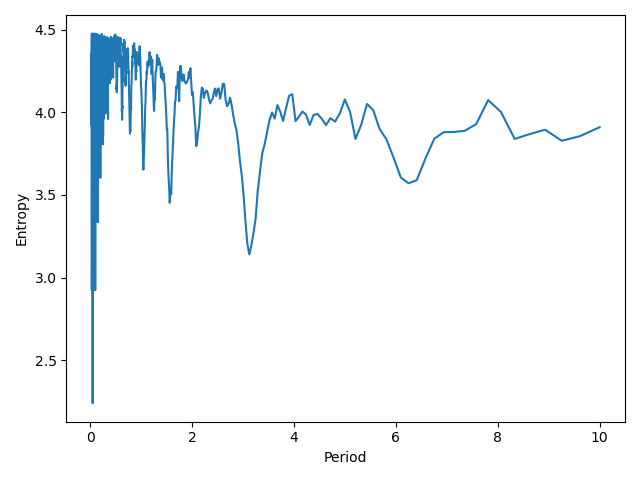

The best fit period is: 0.0503


In [41]:
f_grid = np.arange(1/np.ptp(x), 3*10, 1/5/np.ptp(x)/5)
se_p = se_periodogram(y, x, f_grid)

fig,ax = plt.subplots()
ax.plot(1/f_grid,se_p)
ax.set_xlabel("Period")
ax.set_ylabel("Entropy")
fig.tight_layout()

print("The best fit period is: {:.4f}".format(1/f_grid[np.argmin(se_p)]))


# for 200 x points:
# First, How to stop graph only appearing in small window
# Second, it didn't work. For sufficiently spaced grid (smaller spacing than 1/5/np.ptp(x) needed) we get peak at 3.14, but it is not smallest peak.
# This is window function, largest peaks are at periods of 0.05 and harmonics (window function is evenly spaced at intervals of 0.05)
# Finally, it does work if you don't search frequencies high enough to find window frequency, 
# but if you do window will always win as when folded at window period all points are in same phase box - low shannon entropy
# I think this is why conditional entropy doesn't have this problem

## Problem 3) The Conditional Entropy

The CE is very similar to the Shannon entropy, though we need to condition the calculation on the occupation probability of the partitions in phase.

**Problem 3a** 

Write a function `conditional_entropy` to calculate the CE, $H_c$, for a timeseries, $m(t_i)$, at a given period, `p`.

*Hint* - if you use `histogram2d` be sure to sum along the correct axes

*Hint 2* - recall from session 8 that we want to avoid `for` loops, try to vectorize your calculation.

In [51]:
def conditional_entropy(m, t, p):
    '''Calculate the conditional entropy
    
    Parameters
    ----------
    m : array-like
        brightness measurements of the time-series data
    
    t : array-like
        timestamps corresponding to the brightness measurements
    
    p : float
        period of the periodic signal
        
    Returns
    -------
    Hc : float
        Conditional entropy for m(t) at period p
    '''
    
    m_norm = (m-m.min())/m.ptp()
    phases = (t/p)%1
    H, _, _ = np.histogram2d(phases,m_norm,bins=(np.linspace(0,1,11), np.linspace(0,1,11)))
    
    p_m_phi = H/H.sum()
    p_phi = np.repeat((H.sum(1)/H.sum()).reshape(10,1),10,1) # kept as same shape as H and p_m_phi
    # alternately H.sum(1,keepdims=True)/H.sum()
    
    Hc = -np.sum(p_m_phi[H>0]*np.log(p_m_phi[H>0]/p_phi[H>0]))
    return Hc
# H[i,j] is sum in ith bin in x, jth bin in y

**Problem 3b**

What is the conditional entropy for the simulated signal at periods = 1, $\pi$-0.05, and $\pi$?

Do these results make sense given your understanding of CE?

In [52]:
print('For p = 1, \t\tH_c = {:.5f}'.format(conditional_entropy(y,x,1)))
print('For p = pi - 0.05, \tH_c = {:.5f}'.format(conditional_entropy(y,x,np.pi-0.05)))
print('For p = pi, \t\tH_c = {:.5f}'.format(conditional_entropy(y,x,np.pi)))

# Adam's answers: different

For p = 1, 		H_c = 1.84676
For p = pi - 0.05, 	H_c = 0.93354
For p = pi, 		H_c = 0.87731


**Problem 3c**

Write a function, `ce_periodogram`, to calculate the conditional entropy for observations $m$, $t$ over a frequency grid `f_grid`.

In [53]:
def ce_periodogram(m, t, f_grid):
    '''Calculate the conditional entropy at every freq in f_grid
    
    Parameters
    ----------
    m : array-like
        brightness measurements of the time-series data
    
    t : array-like
        timestamps corresponding to the brightness measurements
    
    f_grid : array-like
        trial periods for the periodic signal
        
    Returns
    -------
    ce_p : array-like
        conditional entropy for m(t) at every trial freq
    '''
    
    ce_p = np.zeros_like(f_grid)
    for f_num, f in enumerate(f_grid):
        ce_p[f_num] = conditional_entropy(y,x,1/f)
    
    return ce_p

**Problem 3d**

Plot the conditional entropy periodogram, and return the best-fit period from the periodogram.

<IPython.core.display.Javascript object>


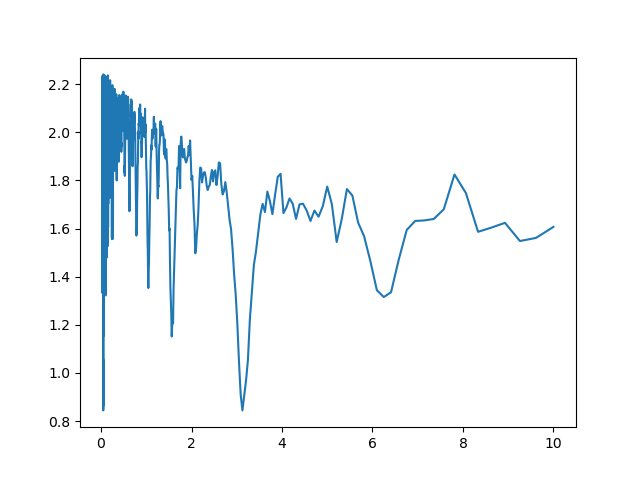

In [54]:
f_grid = np.arange(1/np.ptp(x), 3*10, 1/5/np.ptp(x)/5)
ce_p = ce_periodogram(y,x,f_grid)

fig,ax = plt.subplots()
ax.plot(1/f_grid,ce_p)

#print("The best fit period is: {:.4f}".format( # complete

# unsure if this is right, still getting massivle peak at zero
# To do: check Adam's implementation, finish notebook
#Take away: conditional entropy improves on shannon entropy by encouraging a spread in phase
# It works well on real data: non-sinusoidal and outliers 

The Shannon entropy and CE return nearly identical results for a simulated sinusoidal signal. Now we will examine how each performs with actual astronomical observations. 

## Problem 4) SE vs. CE for real observations

**Problem 4a**

Load the data from our favorite eclipsing binary from this morning's LS exercise. Plot the light curve. 

*Hint* - if you haven't already, download the [example light curve](https://northwestern.box.com/s/rclcz4lkcdfjn4829p8pa5ddfmcyd0gm).

<IPython.core.display.Javascript object>


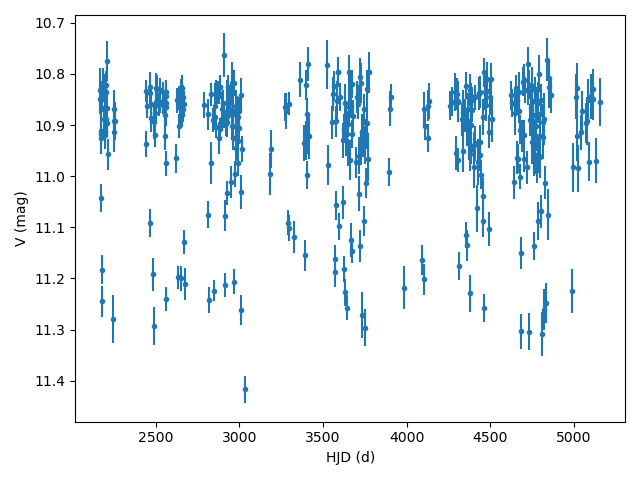

In [55]:
data = pd.read_csv("example_asas_lc.dat")

fig, ax = plt.subplots()
x=data['hjd']
y=data['mag']
y_unc = data['mag_unc']

ax.errorbar(x,y,y_unc,fmt='.')
ax.set_xlabel('HJD (d)')
ax.set_ylabel('V (mag)')
ax.set_ylim(ax.get_ylim()[::-1])
fig.tight_layout()

**Problem 4b** 

Using the Shannon entropy, determine the best period for this light curve.

*Hint* - recall this morning's discussion about the optimal grid for a period search

In [ ]:
f_min = 1/np.ptp(x)
f_max = 30
delta_f = 1/5/np.ptp(x)

f_grid = np.arange(f_min,f_max,delta_f)

In [ ]:
se_p = # complete

print("The best fit period is: {:.9f}".format( # complete

**Problem 4c**

Plot the Shannon entropy periodogram.

In [ ]:
fig, ax = plt.subplots()
# complete
# complete
# complete

**Problem 4d**

Plot the light curve phase-folded on the best-fit period, as measured by the Shannon entropy periodogram.

Does this look reasonable? Why or why not?

*Hint* - it may be helpful to zoom in on the periodogram.

In [ ]:
phase_plot(# complete

**Problem 4e** 

Using the conditional entropy, determine the best period for this light curve.

In [ ]:
ce_p = # complete

print("The best fit period is: {:.9f}".format( # complete

**Problem 4f**

Plot the CE periodogram.

In [ ]:
fig, ax = plt.subplots()
# complete
# complete
# complete

**Problem 4g**

Plot the light curve phase-folded on the best-fit period, as measured by the CE periodogram.

Does this look reasonable? If not - can you make it look better?

In [ ]:
phase_plot( # complete

This example demonstrates the primary strength of CE over the Shannon entropy. 

If you zoom-in on the CE periodogram, there is no power at $p \approx 1\,\mathrm{d}$, unlike the LS periodogram *or* the Shannon entropy method. This will not be the case for every single light curve, but this is a very nice feature of the CE method. And one reason why it may be preferred to something like LS when analyzing every light curve in LSST.

## Challenge Problem) Overlapping Bins

In the previous example we used a simple uniform grid to identify the best-fit period for the eclipsing binary. However, the "best-fit" resulted in an estimate of the half period. One way to improve upon this estimate is to build a grid that has overlapping phase bins. This requirement results in better continuity in the phase-folded light curves (K.Burdge, private communication).  

**Challenge Problem**

Build a function `conditional_entropy_overlap` that utilizes overlapping bins in the CE calculation. 

Can you use this function to identify the correct period of the binary?